# Corpus and BGRF Composition

We describe and analyse the status quo of the corpus with respect to criteria like author gender, year of first publication, narrative form etc. Then we compare it to the "baseline" of the BGRF.

**Table of Contents**
* [Prerequisites](#Prerequisites)
* [Corpus Metadata](#Corpus-Metadata)
  - [Author Gender](#Author-Gender)
  - [Text Length](#Text-Length)
  - [Publication Date](#Year-of-first-publication)
  - [Narrative Form](#Narrative-Form)
* [BGRF Metadata from Wikibase](#BGRF-Metadata-from-Wikibase)
  - [Configuration](#Configuration)
  - [Data Loading](#Data-Loading)
  - [Author Gender](#Author-Gender-(BGRF))
  - [Text Length](#Text-Length-(BGRF))
  - [Publication Date](#Publication-Date-(BGRF))
  - [Narrative Form](#Narrative-Form-(BGRF))
* [Comparison](#Comparison)
  - [Publication Date](#Publication-Date-(Corpus-vs-BGRF))
  

## Prerequisites

In [341]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

# Install with e.g. `pip install sparqlwrapper`
from SPARQLWrapper import SPARQLWrapper, JSON

# Make plots appear directly in the notebook.
%matplotlib inline

The later parts also require access to a Wikibase instance, which is only accessible in/over the university network.

## Corpus Metadata

In [342]:
# Adjust the URL to the .tsv file as needed.
DATA_URL = 'https://raw.githubusercontent.com/MiMoText/roman18/master/XML-TEI/xml-tei_metadata.tsv'
corpus = pd.read_csv(DATA_URL, sep='\t')
print('Available column names:', corpus.columns.values)

Available column names: ['filename' 'au-name' 'title' 'au-gender' 'firsted-yr' 'printSource-yr'
 'form' 'spelling' 'data-capture' 'token count' 'size' 'bgrf']


### Author Gender

Data is in the column 'au-gender'. Possible values are 'F', 'M' and 'U'.

Set of all occuring values: {'U', 'F', 'M'}
% of female authors: 	0.184
% of male authors: 	0.789
% of unknown/other: 	0.026


Text(0, 0.5, 'Count in corpus')

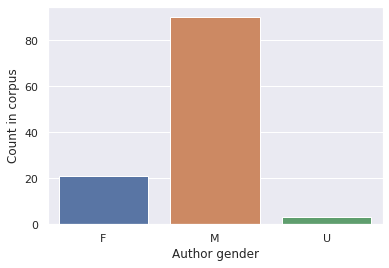

In [343]:
gender = corpus['au-gender'].astype('category')
print('Set of all occuring values:', set(gender.values))
ratio_female = (gender == 'F').sum() / gender.count()
ratio_male = (gender == 'M').sum() / gender.count()
ratio_other = 1 - ratio_female - ratio_male
print(
    f'% of female authors: \t{ratio_female:.3f}\n'
    f'% of male authors: \t{ratio_male:.3f}\n'
    f'% of unknown/other: \t{ratio_other:.3f}'
)
sns.countplot(x=gender)
plt.xlabel('Author gender')
plt.ylabel('Count in corpus')

### Text Length
Data is in the column 'size', possible values are 'short', 'medium', 'long'.

% of short texts: 	0.491
% of medium texts: 	0.289
% of long texts: 	0.219


Text(0, 0.5, 'Count in corpus')

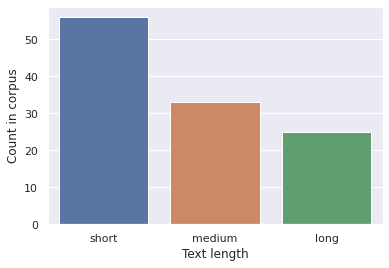

In [344]:
size = corpus['size']
ratio_size_short = (size == 'short').sum() / size.count()
ratio_size_med = (size == 'medium').sum() / size.count()
ratio_size_long = (size == 'long').sum() / size.count()
print(
    f'% of short texts: \t{ratio_size_short:.3f}\n'
    f'% of medium texts: \t{ratio_size_med:.3f}\n'
    f'% of long texts: \t{ratio_size_long:.3f}'
)
sns.countplot(x=size)
plt.xlabel('Text length')
plt.ylabel('Count in corpus')

### Year of first publication
Data is in the column 'firsted-yr'. However, possible values can be single years `(yyyy)`, year spans `(yyyy-yyyy)`, the floating point number value `NaN`, or even a string like `'unknown'`. Therefore, we need to clean up a bit before we can use it. In case of year ranges, we simply use the first year.

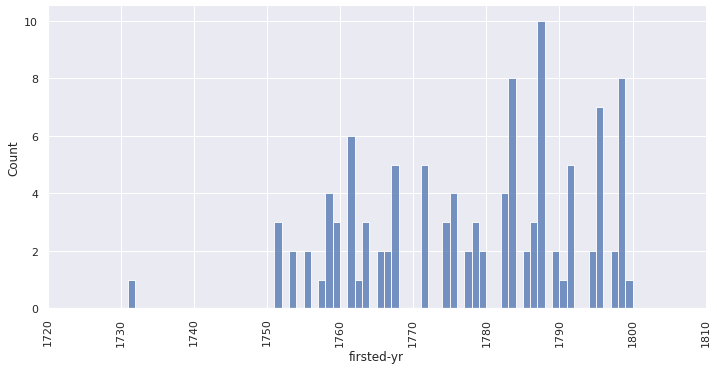

In [345]:
pubyear = (corpus['firsted-yr']
    .astype('|S')
    .replace('(\d{4})-\d{4}', '\1', regex=True)
    .str.decode('utf-8'))
pubyear = pd.to_datetime(pubyear, errors='coerce')

#pubyear = pd.to_numeric(pubyear, errors='coerce').astype('Int64')
time_range = pubyear.max().year - pubyear.min().year
plot = sns.displot(x=pubyear, bins=time_range, height=5, aspect=16/8)
plot.set_xticklabels(rotation=90)

### Narrative form
Data is in the column 'form'. Possible values include `'mixed'`, `'autodiegetic'`, `'heterodiegetic'`, `'homodiegetic'`, `'epistolary'`, `'dialogue novel'` and also `NaN`.

Set of all values:  {nan, 'autodiegetic', 'epistolary', 'heterodiegetic', 'homodiegetic', 'mixed', 'dialogue novel'}
% of mixed: 	0.036
% of autodiegetic: 	0.250
% of heterodiegetic: 	0.348
% of homodiegetic: 	0.036
% of epistolary: 	0.268
% of dialogue novel: 	0.062


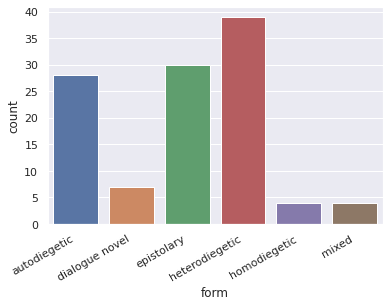

In [346]:
form = corpus['form'].astype('category')
print('Set of all values: ', set(form.values))
print('\n'.join([
    f'% of {kind}: \t{((form==kind).sum()/form.count()):.3f}'
    for kind in [
        'mixed', 'autodiegetic', 'heterodiegetic', 'homodiegetic',
        'epistolary', 'dialogue novel'
    ]
]))
plot = sns.countplot(x=form)
_ = plt.xticks(rotation=30, horizontalalignment='right')

## BGRF Metadata from Wikibase
Data is pulled from Wikibase. For the moment, our instance on port 53100 is used. This may change in the future, which then will not only affect the URL but also the IDs of the items and predicates. Adjust these accordingly in the [Configuration Section](#Configuration).

### Configuration

In [347]:
# Adjust these values whenever another Wikibase instance is to be used.
WB_URL = 'http://zora.uni-trier.de:53100'
ITEM_IDS = {
    'publication_date': 'P7',
    'publication_date_str': 'P43',  # hard to use, since not normalized
    'sex_or_gender': 'P29',         # currently no data on :53100
    'narrative_form': 'P55',        # currently no data on :53100
    'narrative_form_str': 'P47',
    'page_count': 'P35',            # currently no data on :53100
    'page_count_str': 'P45',
    'distribution_format_str': 'P46',
    'distribution_format': 'P38',   # currently no data on :53100
}

### Data Loading

We use the SPARQL endpoint to query the bibliography metadata. Each metadatum gets its own query to enhance recall (otherwise some items which have some, but not all, properties set, would get filtered out. This is particularly relevant because there is no data on gender in Wikibase, yet).

In [348]:
bgrf = pd.DataFrame()
wb_endpoint = f'{WB_URL}/proxy/wdqs/bigdata/namespace/wdq/sparql'

def get_data(endpoint, query):
    '''Given an endpoint URL and a SPARQL query, return
    the data as JSON.
    '''
    user_agent = 'jupyter notebook'
    sparql = SPARQLWrapper(endpoint, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()["results"]["bindings"]

This wrapper function conveniently provides the data as python dictionaries.
For example, to get all the data values for the property `narrative_form_str`,
we can use the following:

In [349]:
ex_query = 'SELECT DISTINCT ?form WHERE { ?item wdt:P46 ?form. }'
results = get_data(wb_endpoint, ex_query)
print('Number of distinct values:', len(results))
print('Each entry has the following form (NPI):', results[0])

Number of distinct values: 38
Each entry has the following form (NPI): {'form': {'xml:lang': 'fr', 'type': 'literal', 'value': 'in—18'}}


The key `'form'` corresponds to us choosing `?form` as the output variable in our SPARQL query.

### Author Gender (BGRF)

In [350]:
# Author gender
# NOTE: currently no data in Wikibase at :44100.
query = ''.join([
    'SELECT ?item ?gender ',
    'WHERE { ?item wdt:',
    ITEM_IDS['sex_or_gender'],
    ' ?gender. }'
])
gender = get_data(wb_endpoint, query)

### Text Length (BGRF)

In [351]:
# Page count
# NOTE: I do not know yet how to estimate the text length based
#       on only the page count.
query = ''.join([
    'SELECT ?item ?pages ',
    'WHERE { ?item wdt:',
    ITEM_IDS['page_count_str'],
    ' ?pages. }'
])
page_count = get_data(wb_endpoint, query)

### Publication Date (BGRF)

The new data Series looks like this:
 http://zora.uni-trier.de:53000/entity/Q28   1751-01-01
http://zora.uni-trier.de:53000/entity/Q30   1752-01-01
http://zora.uni-trier.de:53000/entity/Q32   1753-01-01
Name: pubyear, dtype: datetime64[ns]


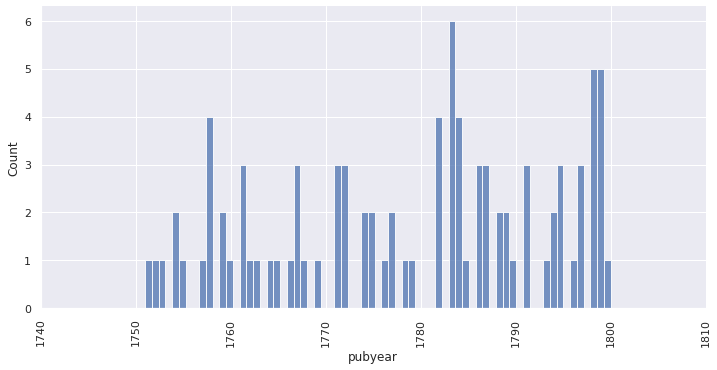

In [352]:
# Publication date
import datetime as dt

query = ''.join([
    'SELECT ?item ?pubdate ',
    'WHERE { ?item wdt:',
    ITEM_IDS['publication_date'],
    ' ?pubdate. }'
])
pubdate = get_data(wb_endpoint, query)

bgrf['pubyear'] = pd.Series(
    data=[dt.date.fromisoformat(entry['pubdate']['value'].split('T')[0]) for entry in pubdate],
    index=[entry['item']['value'] for entry in pubdate],
    dtype='datetime64[ns]'
)

print('The new data Series looks like this:\n', bgrf['pubyear'].head(3))

year_range = bgrf['pubyear'].max().year - bgrf['pubyear'].min().year
plot = sns.displot(x=bgrf['pubyear'], bins=time_range, height=5, aspect=16/8)
plot.set_xticklabels(rotation=90)

### Narrative Form (BGRF)

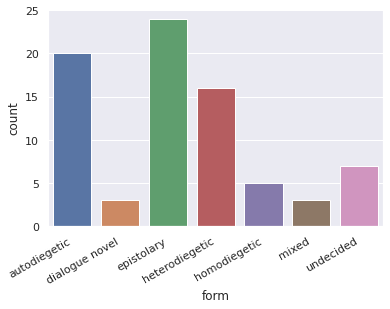

In [353]:
# Narrative form
query = ''.join([
    'SELECT ?item ?form ',
    'WHERE { ?item wdt:',
    ITEM_IDS['narrative_form_str'],
    ' ?form. }'
])
form = get_data(wb_endpoint, query)
form = pd.Series(
    data=[entry['form']['value'] for entry in form],
    index=[entry['item']['value'] for entry in form],
    dtype='category'
)
# This is brutish, but I do not want to write some elaborate
# regexes for something which is essentially still undecided as far
# as the adequate modelling goes.
mapping = {
    'Dialogues': 'dialogue novel',
    'Deux récits 1re personne': 'undecided',
    'Ire personne virant à la 3e, avec dialogues': 'undecided',
    'Ire personne (mémoires découpés en lettres)': 'undecided',
    'Saillard Tchemerzine 3e personne': 'heterodiegetic',
    '3e personne, avec récit intercalé 1re personne': 'undecided',
    '1re personne, avec récits intercalés 1re personne': 'autodiegetic',
    '3e personne, avec dialogues, récits intercalés 1re personne, intervention du narrateur': 'undecided',
    '3e partie: Relation du voyage d’un sublunaire; 1re personne avec des récits d’autres voyageurs': 'undecided',
    '1re personne (mémoires)': 'autodiegetic',
    '1re personne (mémoires), avec récit intercalé 1re personne': 'autodiegetic',
    '1re personne, songe': 'autodiegetic',
    'Lettres, avec récits intercalés 1re personne': 'epistolary',
    'Lettres': 'epistolary',
    'Saint-Fargeau Lettres': 'epistolary',
    '3e personne, avec récits intercalés 1re personne et lettres': 'mixed',
    'Dialogue, avec récits racontés par les personnages': 'dialogue novel',
    '3e personne': 'heterodiegetic',
    '3e personne, avec récit de Jezennemours à la 1re personne': 'homodiegetic',
    '3e personne avec des observations 1re personne': 'homodiegetic',
    'Lettres, interrompues par un récit (I, 83 - 160)': 'mixed',
    '1re personne': 'autodiegetic',
    'Lettres, avec deux histoires intercalées': 'mixed',
    'Cadre 1re personne avec récit 1re personne': 'autodiegetic',
    '3e personne, avec contes intercalés 3e personne (I, 43, Le plaisir, conte moral; II, 10, Aventure du pèlerin)': 'homodiegetic',
    '3e personne, interrompu par des conversations': 'homodiegetic',
    'Ire personne': 'autodiegetic',
    '3e personne, avec récits intercalés 1re personne': 'homodiegetic',
}
#print('\n'.join([i for i in set(bgrf['form'].values) ]))
bgrf['form'] = form.replace(mapping).astype('category')
plot = sns.countplot(x=bgrf['form'])
_ = plt.xticks(rotation=30, horizontalalignment='right')

## Comparison

### Publication Date (Corpus vs BGRF)

In [367]:
# Publication year of corpus texts:
year_corpus = (corpus['firsted-yr']
    .astype('|S')
    .replace('(\d{4})-\d{4}', '\1', regex=True)
    .str.decode('utf-8'))
year_corpus = pd.to_datetime(year_corpus, errors='coerce')

# Publication year of BGRF items:
year_bgrf = bgrf['pubyear']

# Create a date index which includes the whole data range
# so that we can fill in missing data points.
idx = pd.date_range(start='1730', end='1800', freq='YS', closed=None)

# In previous visualizations we have used absolute value counts.
# For comparison we obviously need to use relative frequencies instead.
df = pd.DataFrame(index=idx)
df['freq_corpus'] = year_corpus.value_counts(normalize=True)
df['freq_bgrf'] = year_bgrf.value_counts(normalize=True)
df['year'] = df.index.year
print('The data in "wide form"\n', df.head(4), '\n')

# For the visualization we need the data in "long form", i.e. all the
# relative frequencies are in one single column, with another column 
# specifying whether it stems from the corpus or the bibliography.
long = pd.melt(
    df, id_vars=['year'], value_vars=['freq_corpus', 'freq_bgrf'],
    var_name='origin', value_name='rel_freq')

print('The data in "long form"\n', long.head(4))

The data in "wide form"
             freq_corpus  freq_bgrf  year
1730-01-01          NaN        NaN  1730
1731-01-01     0.009174        NaN  1731
1732-01-01          NaN        NaN  1732
1733-01-01          NaN        NaN  1733 

The data in "long form"
    year       origin  rel_freq
0  1730  freq_corpus       NaN
1  1731  freq_corpus  0.009174
2  1732  freq_corpus       NaN
3  1733  freq_corpus       NaN


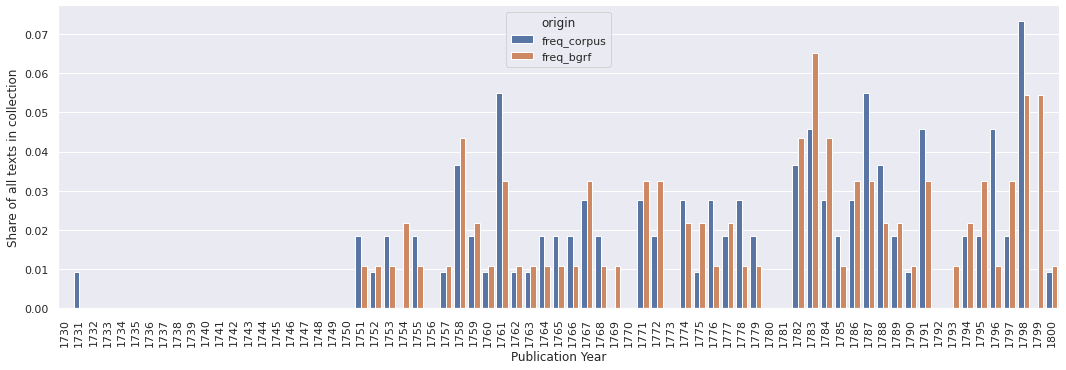

In [368]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long, height=5, aspect=3, legend_out=False)
plt.xlabel('Publication Year')
plt.ylabel('Share of all texts in collection')
_ = plt.xticks(rotation=90)

The outlier with publication year 1731 makes the above chart a bit harder to read than necessary. So let's create the same graph with data starting at 1751.

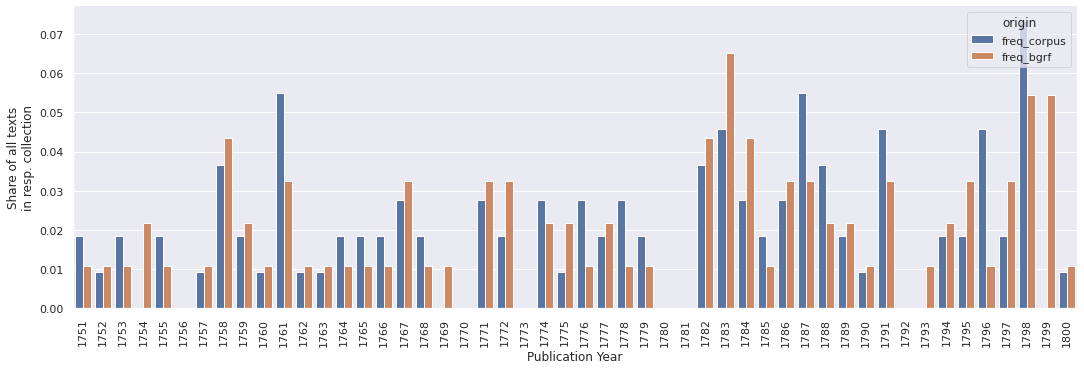

In [370]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long[long['year'] > 1750], height=5, aspect=3,
           legend_out=False)
plt.xlabel('Publication Year')
plt.ylabel('Share of all texts\nin resp. collection')
_ = plt.xticks(rotation=90)